# March Madness Rating Computation

Ranking the teams by their strength is a very important piece of information your model should use.

Some of the rankings are using expert opinion (i.e. majority vote of fan opinion). However, this may be not the best approach, as human opinions tend to be biased towards their favorites. Moreover, it may be easy to determine a top few strong teams, but it is a much harder to rank teams in the mid-lower range ranks.

In NCAA tournament teams are assigned with tournament starting seeds, which also has expert bias - it is not uncommon, that a team with higher win ratio % would get lower seed compared to a team with lower win ratio %, based on the regular season schedule (which is not the same for every team!). Therefore, the judgment of team strength of assigned seed sometimes get controversial opinion among fans and media!

The idea of this kernel is to try to calculate the team strength rankings only based on the  data we have in our disposal. This way we will eliminate all possible human biases and get a robust estimate of team's strength.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from data_format.rating_systems.stephenson import *
from data_format.rating_systems.glicko2 import *
from data_format.rating_systems.elo_v2 import *
import copy

seeds = pd.read_csv('data/mens/MNCAATourneySeeds.csv')
tourney_results = pd.read_csv('data/mens/MNCAATourneyCompactResults.csv')
regular_results = pd.read_csv('data/mens/MRegularSeasonCompactResults.csv')

In [2]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'         
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).sort_index().reset_index(drop=True)
    
    return output

In [3]:
tourney_results = prepare_data(tourney_results)
regular_results = prepare_data(regular_results)

regular_results['T1_TeamID'] = regular_results['T1_TeamID'].astype(str)
regular_results['T2_TeamID'] = regular_results['T2_TeamID'].astype(str)

regular_results['win'] = np.where(regular_results['T1_Score']>regular_results['T2_Score'], 1, 0)

regular_results.head(10)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,win
0,1985,20,1228,81,1328,64,N,0,1
1,1985,20,1328,64,1228,81,N,0,0
2,1985,25,1354,70,1106,77,A,0,0
3,1985,25,1106,77,1354,70,H,0,1
4,1985,25,1112,63,1223,56,H,0,1
5,1985,25,1223,56,1112,63,A,0,0
6,1985,25,1165,70,1432,54,H,0,1
7,1985,25,1432,54,1165,70,A,0,0
8,1985,25,1192,86,1447,74,H,0,1
9,1985,25,1447,74,1192,86,A,0,0


In [4]:
# # regular_results = regular_results[(regular_results['Season'] == 2024)]
# # tourney_results = tourney_results[(tourney_results['Season'] == 2024)]

# combined_teams = pd.concat([regular_results['T1_TeamID'], regular_results['T2_TeamID']]) 
# all_teams = combined_teams.drop_duplicates().tolist()

# team_data = {
#     'team_id': all_teams,   
#     'steph_rating': [Stephenson() for _ in all_teams],
# }

# df_team = pd.DataFrame(team_data)
# df_team.head(10)

In [5]:
def team_quality_s(season):
    year_regular_results = regular_results[(regular_results['Season'] == season)]
    # year_tourney_results = tourney_results[(tourney_results['Season'] == season)]

    combined_teams = pd.concat([year_regular_results['T1_TeamID'], year_regular_results['T2_TeamID']]) 
    all_teams = combined_teams.drop_duplicates().tolist()

    team_data = {
        'TeamID': all_teams,   
        'steph_rating': [Stephenson() for _ in all_teams],
    }

    df_team = pd.DataFrame(team_data)

    for index, row in year_regular_results.iterrows():
        team_one = df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'steph_rating'].values[0]
        team_two = df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'steph_rating'].values[0]

        #Replacing updateVal since this is not by date but by week 10^2 = 100 (cval)
        team_one.sigma = team_one.sigma + 100
        team_two.sigma = team_two.sigma + 100

        # So we don't evaluate on outcome
        home_clone = copy.deepcopy(team_one)

        point_ratio = float(row['T1_Score']) / (row['T1_Score'] + row['T2_Score'])
        # point_ratio = row['win']

        match row['location']:
            case 'H':
                team_one.newVarRating(team_two, point_ratio, 1) #pone is 1 for home team, -1 away, 0 unknown
                team_two.newVarRating(home_clone, (1 - point_ratio), -1) 
            case 'A':
                team_one.newVarRating(team_two, point_ratio, -1)
                team_two.newVarRating(home_clone, (1 - point_ratio), 1) 
            case _:
                team_one.newVarRating(team_two, point_ratio, 0)
                team_two.newVarRating(home_clone, (1 - point_ratio), 0) 

        df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'steph_rating'] = team_one
        df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'steph_rating'] = team_two

    df_team = df_team.assign(quality=df_team['steph_rating'].apply(lambda x: x.getRating()))
    df_team = df_team.sort_values(by="quality", ascending=False)

    # Select only the required columns
    new_team_df = df_team[['TeamID', 'quality']].reset_index(drop=True)
    new_team_df['Season'] = season
    new_team_df['TeamID'] = new_team_df['TeamID'].astype(int)
    return new_team_df

In [6]:
def team_quality(season):
    year_regular_results = regular_results[(regular_results['Season'] == season)]
    # year_tourney_results = tourney_results[(tourney_results['Season'] == season)]

    combined_teams = pd.concat([year_regular_results['T1_TeamID'], year_regular_results['T2_TeamID']]) 
    all_teams = combined_teams.drop_duplicates().tolist()

    team_data = {
        'TeamID': all_teams,   
        'steph_rating': [Rating() for _ in all_teams],
    }

    df_team = pd.DataFrame(team_data)

    for index, row in year_regular_results.iterrows():
        team_one = df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'steph_rating'].values[0]
        team_two = df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'steph_rating'].values[0]

        # So we don't evaluate on outcome
        home_clone = copy.deepcopy(team_one)

        point_ratio = float(row['T1_Score']) / (row['T1_Score'] + row['T2_Score'])
        # point_ratio = row['win']

        team_one.update_player(team_two.getRating(), team_two.getRd(), point_ratio)
        team_two.update_player(home_clone.getRating(), home_clone.getRd(), (1 - point_ratio))
 
        df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'steph_rating'] = team_one
        df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'steph_rating'] = team_two

    df_team = df_team.assign(quality=df_team['steph_rating'].apply(lambda x: x.getRating()))
    df_team = df_team.sort_values(by="quality", ascending=False)

    # Select only the required columns
    new_team_df = df_team[['TeamID', 'quality']].reset_index(drop=True)
    new_team_df['Season'] = season
    new_team_df['TeamID'] = new_team_df['TeamID'].astype(int)
    return new_team_df

In [7]:
def team_quality_elo(season):
    year_regular_results = regular_results[(regular_results['Season'] == season)]

    combined_teams = pd.concat([year_regular_results['T1_TeamID'], year_regular_results['T2_TeamID']]) 
    all_teams = combined_teams.drop_duplicates().tolist()

    team_data = {
        'TeamID': all_teams,   
        'quality': [E_START_RATING] * len(all_teams)
    }

    df_team = pd.DataFrame(team_data)

    for index, row in year_regular_results.iterrows():
        team_one = df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'quality'].values[0]
        team_two = df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'quality'].values[0]

        # point_ratio = float(row['T1_Score']) / (row['T1_Score'] + row['T2_Score'])
        point_ratio = row['win']

        new_team_one, new_team_two = base_competing_elo(team_one, team_two, point_ratio)
 
        df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'quality'] = new_team_one
        df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'quality'] = new_team_two

    df_team = df_team.sort_values(by="quality", ascending=False)

    # Select only the required columns
    new_team_df = df_team[['TeamID', 'quality']].reset_index(drop=True)
    new_team_df['Season'] = season
    new_team_df['TeamID'] = new_team_df['TeamID'].astype(int)
    return new_team_df

In [8]:
team_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024)
                         ]).reset_index(drop=True)

<Axes: ylabel='Density'>

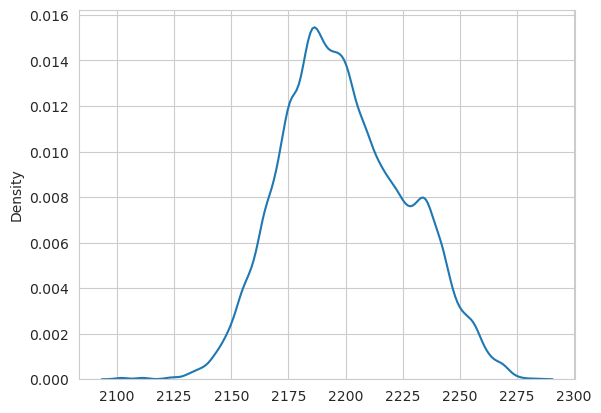

In [9]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# team_quality[["quality"]] = scaler.fit_transform(team_quality[["quality"]]) 

sns.set_style('whitegrid')
sns.kdeplot(np.array(team_quality['quality']), bw_method=0.1)

# March Madness teams - team strength overview

In [10]:
team_quality_T1 = team_quality[['TeamID','Season','quality']]
team_quality_T1.columns = ['T1_TeamID','Season','T1_quality']
team_quality_T2 = team_quality[['TeamID','Season','quality']]
team_quality_T2.columns = ['T2_TeamID','Season','T2_quality']

tourney_results['T1_TeamID'] = tourney_results['T1_TeamID'].astype(int)
tourney_results['T2_TeamID'] = tourney_results['T2_TeamID'].astype(int)
tourney_results = tourney_results.merge(team_quality_T1, on = ['T1_TeamID','Season'], how = 'left')
tourney_results = tourney_results.merge(team_quality_T2, on = ['T2_TeamID','Season'], how = 'left')

In [11]:
# we only have tourney results since year 2010
tourney_results = tourney_results.loc[tourney_results['Season'] >= 2010].reset_index(drop=True)

# not interested in pre-selection matches
tourney_results = tourney_results.loc[tourney_results['DayNum'] >= 136].reset_index(drop=True)

In [12]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds['division'] = seeds['Seed'].apply(lambda x: x[0])

seeds_T1 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T2 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed','T1_division']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed','T2_division']

tourney_results = tourney_results.merge(seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_results = tourney_results.merge(seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [13]:
tourney_results = tourney_results.dropna()

tourney_results['T1_powerrank'] = tourney_results.groupby(['Season','T1_division'])['T1_quality'].rank(method='dense', ascending=False).astype(int)
tourney_results['T2_powerrank'] = tourney_results.groupby(['Season','T2_division'])['T2_quality'].rank(method='dense', ascending=False).astype(int)

In [14]:
piv = pd.pivot_table(tourney_results, index = ['T1_seed'], columns=['T1_powerrank'], values = ['T1_TeamID'], aggfunc=len)
piv = piv.xs('T1_TeamID', axis=1, drop_level=True)

<Axes: xlabel='T1_powerrank', ylabel='T1_seed'>

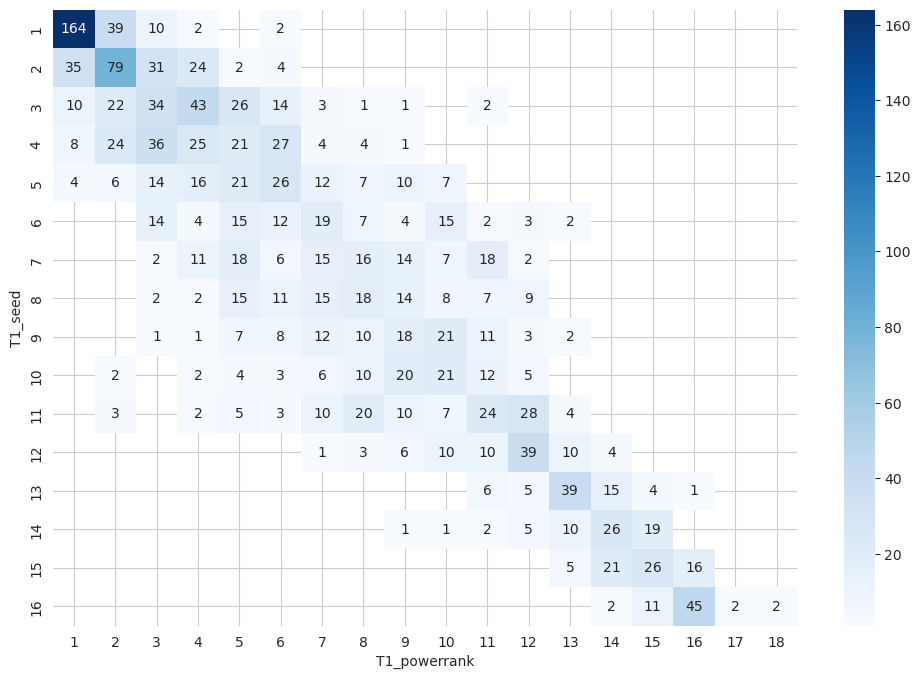

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(piv, annot=True,cmap='Blues', fmt='g')

In [16]:
tourney_results['win'] = np.where(tourney_results['T1_Score'] > tourney_results['T2_Score'], 1, 0)

In [17]:
mean_win_ratio = pd.DataFrame({'seed_win_ratio': tourney_results.groupby('T1_seed')['win'].mean(),
                               'powerrank_win_ratio': tourney_results.groupby('T1_powerrank')['win'].mean()})
mean_win_ratio

,seed_win_ratio,powerrank_win_ratio
1,0.788018,0.791855
2,0.685714,0.691429
3,0.647436,0.611111
4,0.633333,0.583333
5,0.544715,0.589552
6,0.422680,0.517241
7,0.495413,0.422680
8,0.445545,0.416667
9,0.404255,0.434343
10,0.352941,0.422680


<Axes: ylabel='seed_win_ratio'>

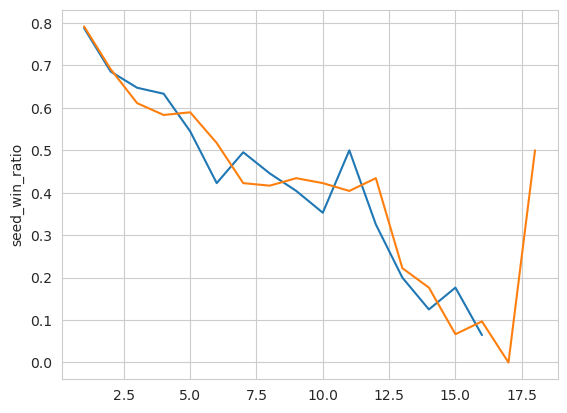

In [18]:
sns.set_style('whitegrid')
sns.lineplot(mean_win_ratio['seed_win_ratio']) # Blue
sns.lineplot(mean_win_ratio['powerrank_win_ratio']) # Orange

In [19]:
from sklearn.metrics import roc_auc_score

print(f"seed AUC: {roc_auc_score(tourney_results['win'],-tourney_results['T1_seed'])}")
print(f"powerrank AUC: {roc_auc_score(tourney_results['win'],-tourney_results['T1_powerrank'])}")
print(f"team quality AUC: {roc_auc_score(tourney_results['win'],tourney_results['T1_quality'])}")

seed AUC: 0.7185317118324874
powerrank AUC: 0.7134801621500846
team quality AUC: 0.7147888537776501
